In [2]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=09d83fc83d9063cc28d59005fac1e8b7bb558c82051908255eb0c376cc5da912
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [1]:
!git clone https://github.com/emanuel-metzenthin/Lime-For-Time.git

Cloning into 'Lime-For-Time'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 193 (delta 33), reused 41 (delta 20), pack-reused 129
Receiving objects: 100% (193/193), 3.09 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [3]:
from google.colab import files
src = list(files.upload().values())[0]
open('lime_timeseries.py','wb').write(src)
import lime_timeseries

Saving lime_timeseries.py to lime_timeseries.py


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
import math

from lime_timeseries import LimeTimeSeriesExplainer

In [5]:
df = pd.read_csv('/content/drive/MyDrive/training_preproc_dataframe_norm_peak_max.csv', index_col=[0])

from scipy import sparse
from scipy.sparse.linalg import spsolve

mz_int = np.arange(start=620, stop=3201)

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z


In [6]:
from sklearn.model_selection import train_test_split

y = df.iloc[:,-1]
X = df.iloc[:,0:-1].values

for i in range(0, X.shape[0]):
  baseline = baseline_als(X[i,:], 10e2, 0.001)
  X[i,:] = X[i,:] - baseline

for i in range(0, X.shape[0]):
  for j in range(0, X.shape[1]):
    if X[i,j] < 0:
      X[i,j] = X[i,j]*(-1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print('Accuracy RF for pure tumours dataset: %f' % (acc(y_test, rf.predict(X_test))))


Accuracy RF for pure tumours dataset: 0.991178


In [ ]:
print(y_test)

59663    1
51777    1
72178    1
38260    0
17376    0
        ..
12471    0
57423    1
56513    1
11888    0
30629    0
Name: Labels, Length: 23917, dtype: int64


In [ ]:
idx = 23912 # explained instance
num_features = 10 # how many feature contained in explanation
num_slices = 258 # split time series
series = X_test[idx, :]

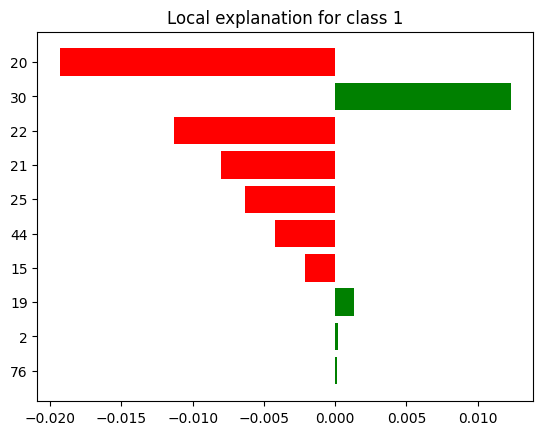

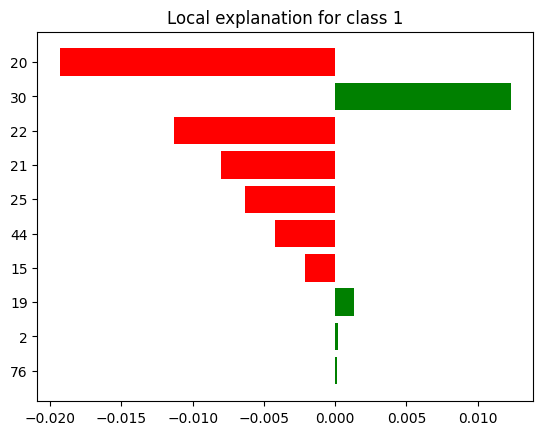

In [ ]:
explainer = LimeTimeSeriesExplainer(class_names=['0', '1'])
exp = explainer.explain_instance(series, rf.predict_proba, num_features=num_features, num_samples=5000, num_slices=num_slices, 
                                 replacement_method='total_mean')
exp.as_pyplot_figure()

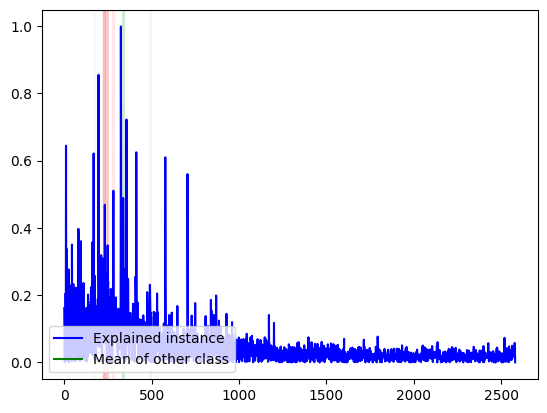

In [ ]:
values_per_slice = math.ceil(len(series) / num_slices)
plt.plot(series, color='b', label='Explained instance')
plt.plot(X_test[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*10))
plt.show()